In [1]:
import numpy as np 
import pandas as pd 
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_rows', 100)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

import warnings
warnings.filterwarnings("ignore")

In [2]:
def aic(y,y_pred, X):
    
    # Compute the residual sum of squares (RSS)
    RSS = np.sum((y - y_pred)**2)

    # Compute the number of parameters in the model
    k = X.shape[1] + 1

    # Compute the AIC score
    AIC = 2*k - 2*np.log(RSS)

    return AIC

### Loading the data:

In [6]:
import os

# set the directory containing the CSV files
directory = 'data'

# create an empty list to hold all the dataframes
df_list = []

# iterate over all files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        # read the CSV file into a pandas dataframe
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        
        # append the dataframe to the list
        df_list.append(df)

# concatenate all dataframes in the list into a single dataframe
data = pd.concat(df_list, ignore_index=True)

# print the resulting dataframe
data.head()

,Record ID,Date Time,Solar Avg,Unnamed: 3
0,203.00,01-03-22 0:00,0.00,NaN
1,204.00,01-03-22 0:01,0.00,NaN
2,205.00,01-03-22 0:02,0.00,NaN
3,206.00,01-03-22 0:03,0.00,NaN
4,207.00,01-03-22 0:04,0.00,NaN


In [5]:
data = data.drop(['Record ID','Unnamed: 3'], axis=1)
data.dropna(inplace=True)
data['Date Time'] = pd.to_datetime(data['Date Time'])
data = data.loc[data['Date Time'] <= '2023-03']
data['Date Time'] = data['Date Time'].dt.round('H')
data = data.groupby('Date Time').mean().reset_index()
data.sort_values(by='Date Time',inplace=True)
data.set_index('Date Time', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7651 entries, 2022-01-03 00:00:00 to 2023-03-01 00:00:00
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Solar Avg  7651 non-null   float64
dtypes: float64(1)
memory usage: 119.5 KB


data = data.drop(['Record ID','Unnamed: 3'], axis=1): This line drops two columns named 'Record ID' and 'Unnamed: 3' from the DataFrame data. The axis=1 argument specifies that columns should be dropped.

data.dropna(inplace=True): This line drops all rows from the DataFrame data that contain missing (NaN) values. The inplace=True argument specifies that the DataFrame should be modified in place.

data['Date Time'] = pd.to_datetime(data['Date Time']): This line converts the values in the 'Date Time' column of the DataFrame data to datetime objects using the pd.to_datetime() function. This is done so that the values can be easily sorted and indexed later.

data.drop_duplicates(subset='Date Time',inplace=True): This line drops any rows from the DataFrame data that have duplicate values in the 'Date Time' column. The inplace=True argument specifies that the DataFrame should be modified in place.

data.sort_values(by='Date Time',inplace=True): This line sorts the rows of the DataFrame data by the values in the 'Date Time' column. The inplace=True argument specifies that the DataFrame should be modified in place.

data.set_index('Date Time', inplace=True): This line sets the 'Date Time' column as the index of the DataFrame data. This means that the DataFrame will be indexed by dates and times, which will be useful for time series analysis.

data.info(): This line prints out some basic information about the DataFrame data, including its shape (number of rows and columns), the data types of its columns, and the number of non-null values in each column.

In [10]:
del df_list

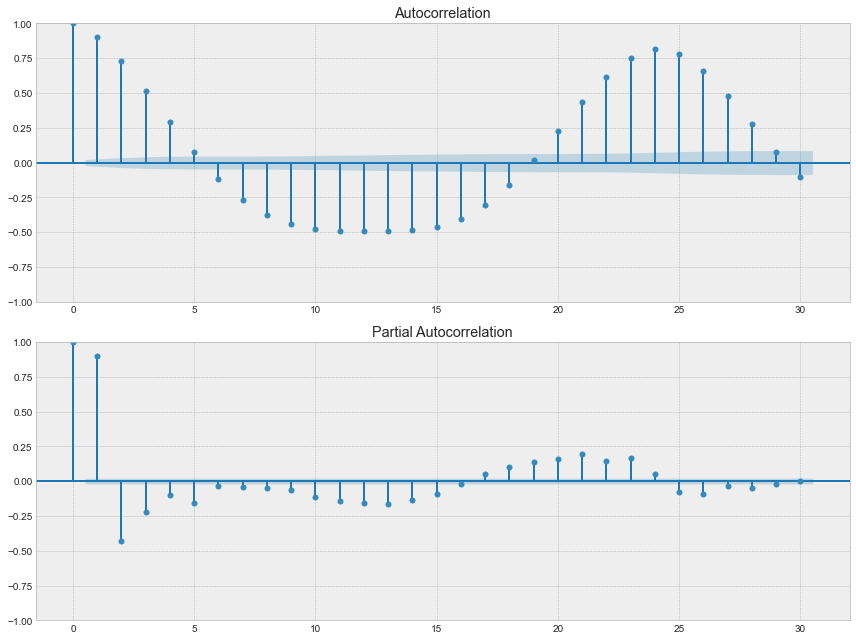

In [11]:
import statsmodels.formula.api as smf        
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

data.sort_index(inplace=True)
with plt.style.context('bmh'):    
    fig = plt.figure(figsize=(12, 9))
    layout = (2, 1)
    acf_ax = plt.subplot2grid(layout, (0, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 0))
    
    smt.graphics.plot_pacf(data['Solar Avg'], ax=pacf_ax,lags=30)
    smt.graphics.plot_acf(data['Solar Avg'], ax=acf_ax,lags=30)
    plt.tight_layout()

This code imports necessary libraries and then creates a figure with two subplots to display the autocorrelation and partial autocorrelation functions for a time series dataset. The sort_index method is called to ensure the data is sorted in the correct order, and then the plot_acf and plot_pacf functions are called to generate the desired plots.

In [12]:
# Genrating needed lags:
for i in range(1,13):
    data["lag_{}".format(i)] = data['Solar Avg'].shift(i)
data.dropna(axis=0,inplace=True)
data.head()

,Solar Avg,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
Date Time,,,,,,,,,,,,,
2022-01-03 12:00:00,943.70,959.81,1141.83,690.23,259.15,71.05,0.75,0.00,0.00,0.00,0.00,0.00,0.00
2022-01-03 13:00:00,995.37,943.70,959.81,1141.83,690.23,259.15,71.05,0.75,0.00,0.00,0.00,0.00,0.00
2022-01-03 14:00:00,955.11,995.37,943.70,959.81,1141.83,690.23,259.15,71.05,0.75,0.00,0.00,0.00,0.00
2022-01-03 15:00:00,810.54,955.11,995.37,943.70,959.81,1141.83,690.23,259.15,71.05,0.75,0.00,0.00,0.00
2022-01-03 16:00:00,396.28,810.54,955.11,995.37,943.70,959.81,1141.83,690.23,259.15,71.05,0.75,0.00,0.00


#### Plotting the correlations:

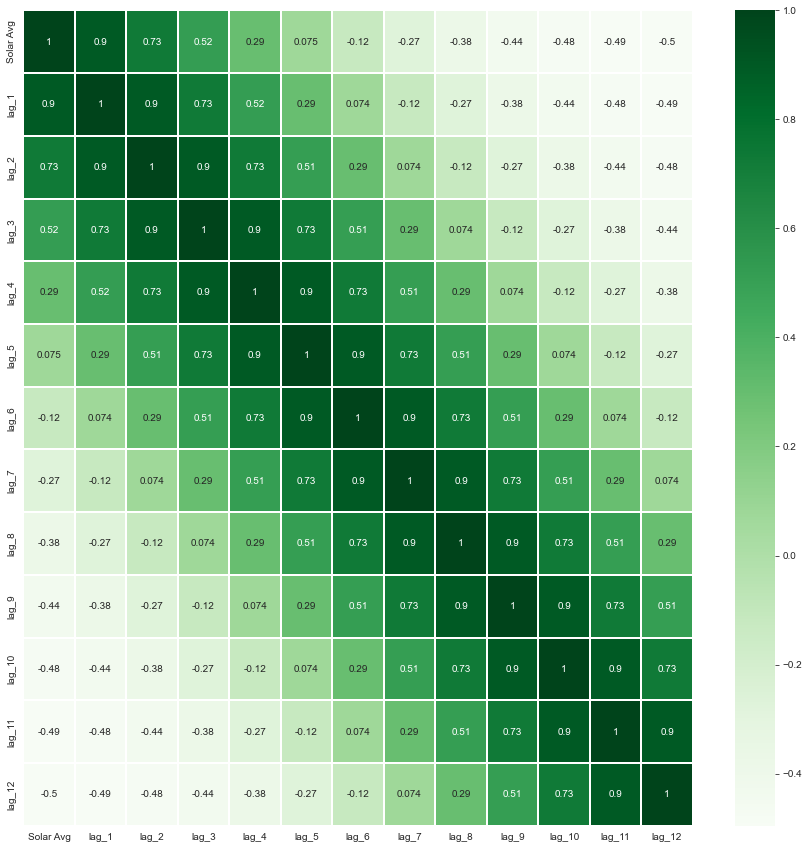

In [13]:
plt.figure(figsize=(15, 15))
sns.heatmap(data.corr(), annot=True, cmap="Greens", linewidths=0.1, annot_kws={"fontsize":10});

In [14]:
data.reset_index().to_csv('Full Data.csv')

In [15]:
# Creating train and test sets:
X = data.drop(['Solar Avg'], axis =1)
y = data['Solar Avg'].to_frame()

# Scaling the data. 
data_scaler = StandardScaler()
target_scaler = StandardScaler()

scaled_data = data_scaler.fit_transform(X.values)
scaled_target = target_scaler.fit_transform(y.values)

scaled_data= pd.DataFrame(scaled_data, index=X.index, columns=X.columns)
scaled_target= pd.DataFrame(scaled_target, index=y.index, columns=y.columns)

x_train, x_test, y_train, y_test = train_test_split(scaled_data,scaled_target,test_size=0.2,shuffle=False, stratify = None)

this code performs data preprocessing tasks by splitting the original dataset into features and target dataframes, standardizing the data using the StandardScaler class, and splitting the data into training and testing sets using the train_test_split function.

## LSTM:

In [16]:
# Import necessary libraries
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from keras import optimizers

# Define a function that creates the LSTM model
def create_lstm_model(learning_rate=0.001, units_1=128, units_2=64):
    model = Sequential()
    model.add(LSTM(units_1, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(units_2, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    adam = optimizers.Adam(lr=learning_rate)
    model.compile(loss='mean_squared_error', optimizer=adam)
    print('#',end='')
    return model

# Create a KerasRegressor from the function above
lstm_model = KerasRegressor(build_fn=create_lstm_model, verbose=0)

# Define the hyperparameters to tune and their possible values
param_grid = {'learning_rate': [0.001, 0.01, 0.1], 'units_1': [64, 128, 256], 'units_2': [32, 64, 128]}

# Use GridSearchCV to find the best hyperparameters
grid = GridSearchCV(estimator=lstm_model, param_grid=param_grid, cv=3)
grid_result = grid.fit(x_train, y_train)

# Print the best hyperparameters
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

##################################################################################Best: -0.138903 using {'learning_rate': 0.001, 'units_1': 128, 'units_2': 64}


this code performs hyperparameter tuning for an LSTM model by creating a function that defines the model architecture, creating a KerasRegressor object from the function, defining a dictionary of hyperparameters to tune, and using GridSearchCV to find the best hyperparameters.

In [17]:
from tensorflow.keras import callbacks

lstm_model = create_lstm_model(learning_rate=grid_result.best_params_['learning_rate'],
                          units_1=grid_result.best_params_['units_1'],
                          units_2=grid_result.best_params_['units_2'])

early_stopping = callbacks.EarlyStopping(monitor='loss', patience=5, min_delta=0.001, restore_best_weights = True)

lstm_model.fit(x_train, y_train, epochs=50, callbacks=[early_stopping])

#Epoch 1/50
191/191 [==============================] - 6s 16ms/step - loss: 0.2249
Epoch 2/50
191/191 [==============================] - 3s 16ms/step - loss: 0.1435
Epoch 3/50
191/191 [==============================] - 3s 16ms/step - loss: 0.1273
Epoch 4/50
191/191 [==============================] - 3s 16ms/step - loss: 0.1289
Epoch 5/50
191/191 [==============================] - 3s 16ms/step - loss: 0.1140
Epoch 6/50
191/191 [==============================] - 3s 17ms/step - loss: 0.1198
Epoch 7/50
191/191 [==============================] - 3s 16ms/step - loss: 0.1156
Epoch 8/50
191/191 [==============================] - 3s 16ms/step - loss: 0.1141
Epoch 9/50
191/191 [==============================] - 3s 16ms/step - loss: 0.1097
Epoch 10/50
191/191 [==============================] - 3s 17ms/step - loss: 0.1131
Epoch 11/50
191/191 [==============================] - 4s 19ms/step - loss: 0.1076
Epoch 12/50
191/191 [==============================] - 4s 20ms/step - loss: 0.1071
Epoch 13/50


This code trains the LSTM model with the best hyperparameters found using GridSearchCV in the previous code block.

In [18]:
LSTMpredictions = lstm_model.predict(x_test)
LSTMpredictions = target_scaler.inverse_transform(LSTMpredictions)
y_test_descaled = target_scaler.inverse_transform(y_test)
lstmmae = mean_absolute_error(y_test_descaled, LSTMpredictions)
lstmmse = mean_squared_error(y_test_descaled, LSTMpredictions)
lstmrmse = np.sqrt(lstmmse)
lstmr2 = r2_score(y_test_descaled, LSTMpredictions)
lstmaic = aic(y_test, LSTMpredictions, x_test)
lstmmape = mean_absolute_percentage_error(y_test, LSTMpredictions) * 100
print(f'''
(a) LSTM Mean Absolute Error (lstmMAE): {lstmmae}
(b) LSTM Mean Squared Error (MlstmSE): {lstmmse}
(c) LSTM Root Mean Squared Errlstmor (RMSE): {lstmrmse}
(d) LSTM R² (R-Squared):{lstmr2}
(e) LSTM AIC : {lstmaic.iloc[0]}
(f) LSTM MAPE : {lstmmape}
''')

48/48 [==============================] - 1s 6ms/step

(a) LSTM Mean Absolute Error (lstmMAE): 61.90868951474267
(b) LSTM Mean Squared Error (MlstmSE): 17316.47791014313
(c) LSTM Root Mean Squared Errlstmor (RMSE): 131.59208908647636
(d) LSTM R² (R-Squared):0.8499740184488387
(e) LSTM AIC : -12.10975493729756
(f) LSTM MAPE : 42813.22172755351



#### Accuracy: 84.5%

#### Plotting the LSTM predictions:

In [19]:
train = data[:len(x_train)]
lstmvalid = data[len(x_train):]
lstmvalid['Predictions'] = LSTMpredictions

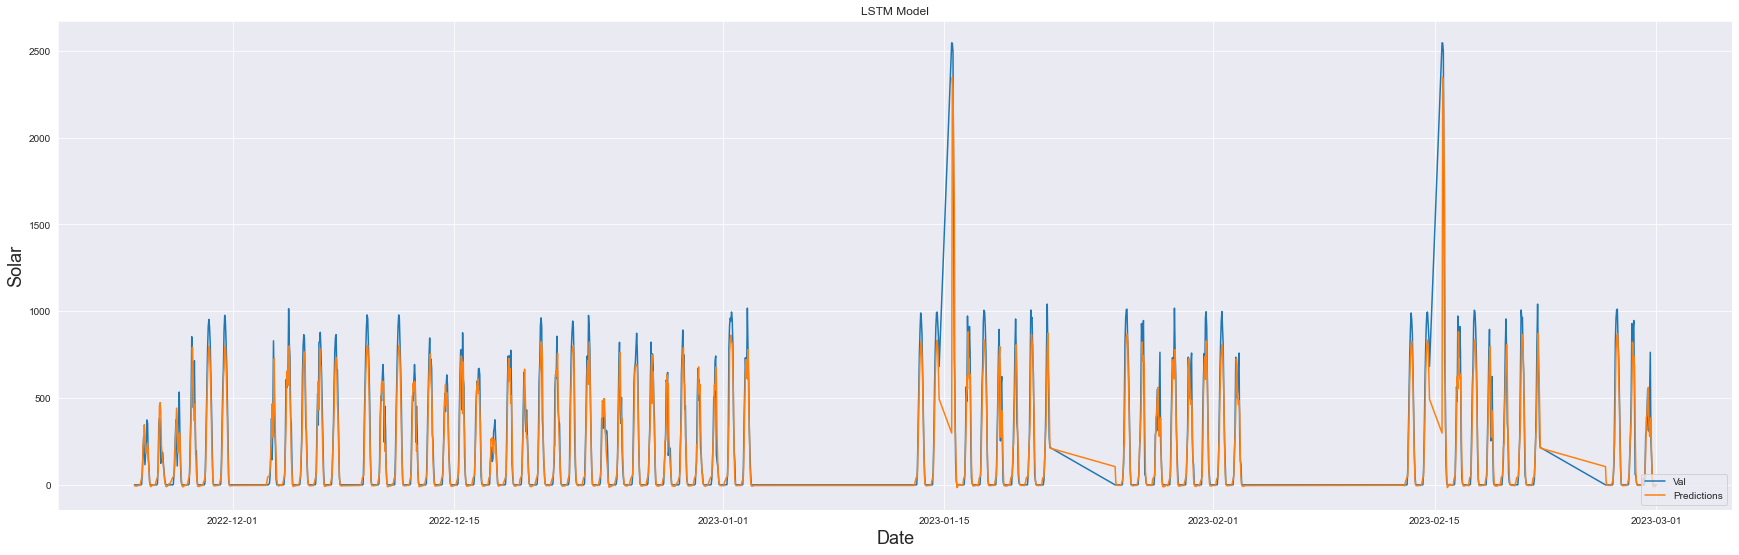

In [20]:
plt.figure(figsize=(30,9))
plt.title('LSTM Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Solar', fontsize=18)
plt.plot(lstmvalid[['Solar Avg', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()

In [21]:
lstmvalid.iloc[:,[0,-1]].to_csv('LSTM predictions.csv')

## ELM:

In [22]:
# define the model
def create_elm_model(hidden_units=64, activation='relu', learning_rate=0.001):
    elm_model = Sequential()
    elm_model.add(Dense(hidden_units, input_dim=x_train.shape[1], activation=activation, kernel_initializer='he_uniform'))
    elm_model.add(Dense(1))
    optimizer = optimizers.Adam(lr=learning_rate)
    elm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    print('#',end='')
    return elm_model

# create a dictionary of hyperparameters to tune
hyperparameters = {'hidden_units': [32, 64, 128],
                   'activation': ['relu', 'tanh', 'sigmoid'],
                   'learning_rate': [0.001, 0.01, 0.1]}

# create a GridSearchCV object
elm_model = KerasRegressor(build_fn=create_elm_model, verbose=0)
grid_search = GridSearchCV(estimator=elm_model, param_grid=hyperparameters, cv=5)

# perform the grid search
grid_result = grid_search.fit(x_train, y_train)

# print the best hyperparameters
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

########################################################################################################################################Best: -0.110395 using {'activation': 'sigmoid', 'hidden_units': 64, 'learning_rate': 0.01}


This code performs hyperparameter tuning using GridSearchCV for an ELM model with a single hidden layer, by testing different combinations of the number of hidden units, activation function, and learning rate, and finds the best hyperparameters that give the highest score.

In [23]:
elm_model = create_elm_model(activation=grid_result.best_params_['activation'],
                          hidden_units=grid_result.best_params_['hidden_units'],
                          learning_rate=grid_result.best_params_['learning_rate'])

elm_model.fit(x_train, y_train, epochs=50, callbacks=[early_stopping])

#Epoch 1/50
191/191 [==============================] - 0s 763us/step - loss: 0.2081
Epoch 2/50
191/191 [==============================] - 0s 718us/step - loss: 0.1052
Epoch 3/50
191/191 [==============================] - 0s 722us/step - loss: 0.1031
Epoch 4/50
191/191 [==============================] - 0s 765us/step - loss: 0.0999
Epoch 5/50
191/191 [==============================] - 0s 756us/step - loss: 0.0958
Epoch 6/50
191/191 [==============================] - 0s 999us/step - loss: 0.0981
Epoch 7/50
191/191 [==============================] - 0s 774us/step - loss: 0.0920
Epoch 8/50
191/191 [==============================] - 0s 725us/step - loss: 0.0911
Epoch 9/50
191/191 [==============================] - 0s 800us/step - loss: 0.0905
Epoch 10/50
191/191 [==============================] - 0s 734us/step - loss: 0.0932
Epoch 11/50
191/191 [==============================] - 0s 823us/step - loss: 0.0886
Epoch 12/50
191/191 [==============================] - 0s 755us/step - loss: 0.0911


This code trains the ELM model with the best hyperparameters found using GridSearchCV in the previous code block.

In [24]:
ELMpredictions = elm_model.predict(x_test)
ELMpredictions = target_scaler.inverse_transform(ELMpredictions)
y_test_descaled = target_scaler.inverse_transform(y_test)
ELMmae = mean_absolute_error(y_test_descaled, ELMpredictions)
ELMmse = mean_squared_error(y_test_descaled, ELMpredictions)
ELMrmse = np.sqrt(ELMmse)
ELMr2 = r2_score(y_test_descaled, ELMpredictions)
ELMaic = aic(y_test, ELMpredictions, x_test)
ELMmape = mean_absolute_percentage_error(y_test, ELMpredictions) * 100
print(f'''
(a) ELM Mean Absolute Error (ELMMAE): {ELMmae}
(b) ELM Mean Squared Error (MELMSE): {ELMmse}
(c) ELM Root Mean Squared ErrELMor (RMSE): {ELMrmse}
(d) ELM R² (R-Squared):{ELMr2}
(e) ELM AIC : {ELMaic.iloc[0]}
(f) ELM MAPE : {ELMmape}
''')

48/48 [==============================] - 0s 605us/step

(a) ELM Mean Absolute Error (ELMMAE): 72.22794678111214
(b) ELM Mean Squared Error (MELMSE): 17086.67872947174
(c) ELM Root Mean Squared ErrELMor (RMSE): 130.71602323155238
(d) ELM R² (R-Squared):0.8519649456927492
(e) ELM AIC : -12.743295141021001
(f) ELM MAPE : 60383.23054414474



#### Accuracy: 81.1%

#### Plotting the ELM predictions:

In [25]:
train = data[:len(x_train)]
elmvalid = data[len(x_train):]
elmvalid['Predictions'] = ELMpredictions

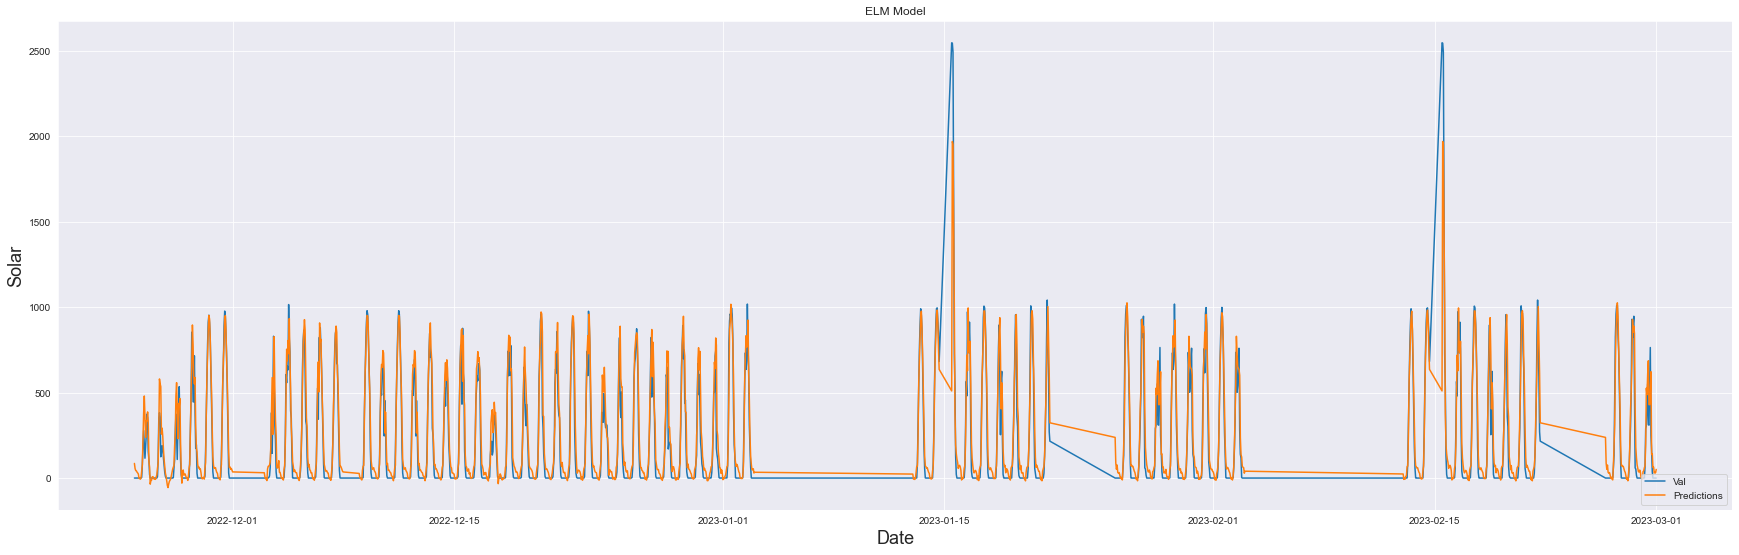

In [26]:
plt.figure(figsize=(30,9))
plt.title('ELM Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Solar', fontsize=18)
# plt.plot(train['AllSky_Irr (Wh/m^2)'])
plt.plot(elmvalid[['Solar Avg', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()

In [27]:
elmvalid.iloc[:,[0,-1]].to_csv('ELM predictions.csv')

##  GRU Model:

In [28]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, GRU
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Define the GRU model
def create_gru_model(n_units=64, input_shape=(x_train.shape[1], 1)):
    model = Sequential()
    model.add(GRU(units=n_units, input_shape=input_shape))
    model.add(Dense(units=1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    print('#',end='')
    return model


# Create a KerasRegressor from the function above
gru_model = KerasRegressor(build_fn=create_gru_model, verbose=0)


# Define the hyperparameters to search over
param_grid = {
    'n_units': [32, 64, 128],
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=gru_model, scoring='neg_mean_squared_error', param_grid=param_grid, cv=5)

# Fit the model to the training data
grid_search.fit(x_train, y_train)

# Print the best parameters and the corresponding RMSE score
print("\nBest using %s" % ( grid_search.best_params_))

################
Best using {'n_units': 128}


In [29]:
gru_model = create_gru_model(n_units=grid_search.best_params_['n_units'])

gru_model.fit(x_train, y_train, epochs=50, callbacks=[early_stopping])

#Epoch 1/50
191/191 [==============================] - 3s 6ms/step - loss: 0.2875
Epoch 2/50
191/191 [==============================] - 1s 6ms/step - loss: 0.1427
Epoch 3/50
191/191 [==============================] - 1s 6ms/step - loss: 0.1245
Epoch 4/50
191/191 [==============================] - 1s 6ms/step - loss: 0.1298
Epoch 5/50
191/191 [==============================] - 1s 6ms/step - loss: 0.1216
Epoch 6/50
191/191 [==============================] - 1s 6ms/step - loss: 0.1150
Epoch 7/50
191/191 [==============================] - 1s 6ms/step - loss: 0.1101
Epoch 8/50
191/191 [==============================] - 1s 7ms/step - loss: 0.1019
Epoch 9/50
191/191 [==============================] - 1s 7ms/step - loss: 0.0991
Epoch 10/50
191/191 [==============================] - 1s 7ms/step - loss: 0.0984
Epoch 11/50
191/191 [==============================] - 1s 6ms/step - loss: 0.1010
Epoch 12/50
191/191 [==============================] - 1s 6ms/step - loss: 0.0939
Epoch 13/50
191/191 [===

In [30]:
GRUpredictions = gru_model.predict(x_test)
GRUpredictions = target_scaler.inverse_transform(GRUpredictions)
y_test_descaled = target_scaler.inverse_transform(y_test)
GRUmae = mean_absolute_error(y_test_descaled, GRUpredictions)
GRUmse = mean_squared_error(y_test_descaled, GRUpredictions)
GRUrmse = np.sqrt(GRUmse)
GRUr2 = r2_score(y_test_descaled, GRUpredictions)
GRUaic = aic(y_test, GRUpredictions, x_test)
GRUmape = mean_absolute_percentage_error(y_test, GRUpredictions) * 100
print(f'''
(a) GRU Mean Absolute Error (GRUMAE): {GRUmae}
(b) GRU Mean Squared Error (MGRUSE): {GRUmse}
(c) GRU Root Mean Squared ErrGRUor (RMSE): {GRUrmse}
(d) GRU R² (R-Squared):{GRUr2}
(e) GRU AIC : {GRUaic.iloc[0]}
(f) GRU MAPE : {GRUmape}
''')

48/48 [==============================] - 0s 2ms/step

(a) GRU Mean Absolute Error (GRUMAE): 58.10704764754177
(b) GRU Mean Squared Error (MGRUSE): 16864.362822332132
(c) GRU Root Mean Squared ErrGRUor (RMSE): 129.86286159765666
(d) GRU R² (R-Squared):0.853891039576051
(e) GRU AIC : -12.720225066584426
(f) GRU MAPE : 55169.97632214554



#### Accuracy: 83.5%

#### Plotting the gru-model predictions:

In [31]:
train = data[:len(x_train)]
hyvalid = data[len(x_train):]
hyvalid['Predictions'] = GRUpredictions

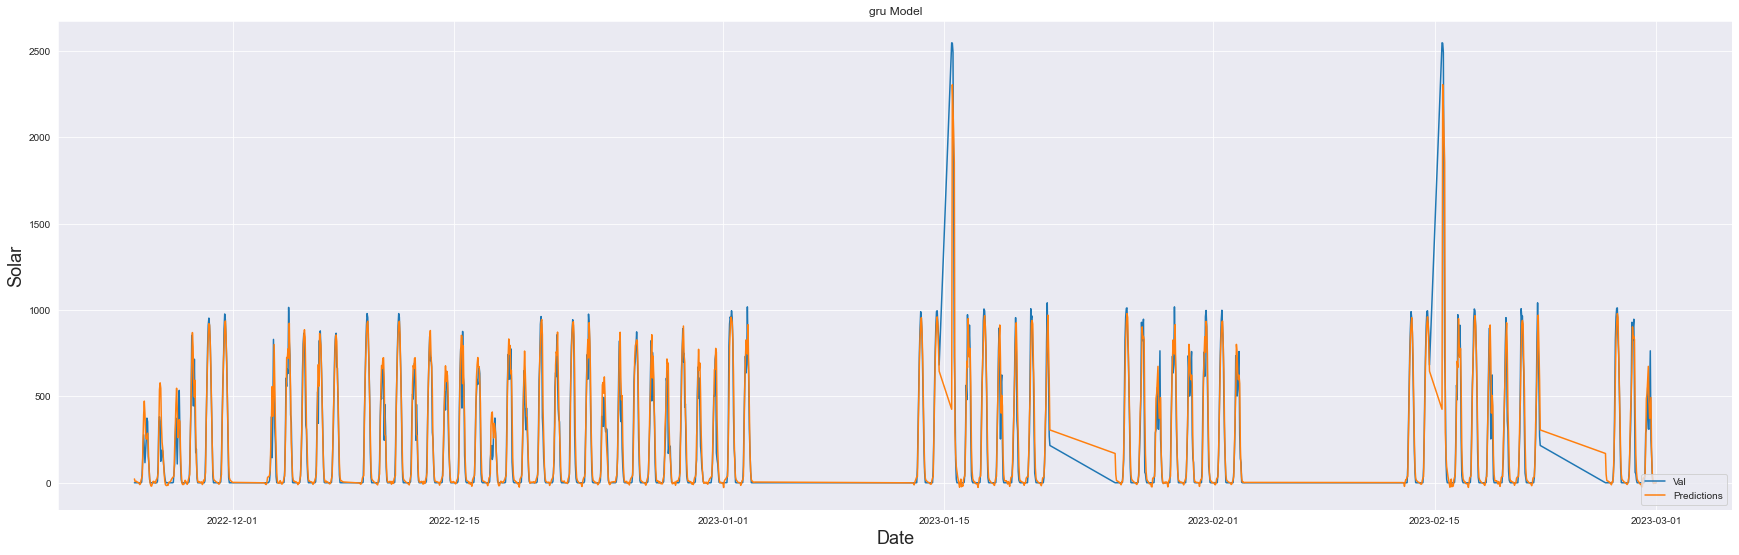

In [32]:
plt.figure(figsize=(30,9))
plt.title('gru Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Solar', fontsize=18)
# plt.plot(train['AllSky_Irr (Wh/m^2)'])
plt.plot(hyvalid[['Solar Avg', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()

In [33]:
hyvalid.iloc[:,[0,-1]].to_csv('gru predictions.csv')

In [34]:
from pickle import dump

with open('target_scaler.pkl', 'wb') as pickle_file:
    dump(target_scaler, pickle_file)
with open('data_scaler.pkl', 'wb') as pickle_file:
    dump(data_scaler, pickle_file)

In [35]:
lstm_model.fit(scaled_data, scaled_target, epochs=50, callbacks=[early_stopping])
lstm_model.save('LSTM.h5')
elm_model.fit(scaled_data, scaled_target, epochs=50, callbacks=[early_stopping])
elm_model.save('ELM.h5')
gru_model.fit(scaled_data, scaled_target, epochs=50, callbacks=[early_stopping])
gru_model.save('gru.h5')

Epoch 1/50
239/239 [==============================] - 2s 10ms/step - loss: 0.1073
Epoch 2/50
239/239 [==============================] - 2s 10ms/step - loss: 0.1056
Epoch 3/50
239/239 [==============================] - 3s 11ms/step - loss: 0.1064
Epoch 4/50
239/239 [==============================] - 2s 10ms/step - loss: 0.1055
Epoch 5/50
239/239 [==============================] - 2s 10ms/step - loss: 0.0970
Epoch 6/50
239/239 [==============================] - 2s 10ms/step - loss: 0.0959
Epoch 7/50
239/239 [==============================] - 2s 10ms/step - loss: 0.1041
Epoch 8/50
239/239 [==============================] - 3s 11ms/step - loss: 0.0994
Epoch 9/50
239/239 [==============================] - 2s 10ms/step - loss: 0.0947
Epoch 10/50
239/239 [==============================] - 3s 11ms/step - loss: 0.0926
Epoch 11/50
239/239 [==============================] - 2s 10ms/step - loss: 0.0941
Epoch 12/50
239/239 [==============================] - 2s 10ms/step - loss: 0.0932
Epoch 13/50
2